In [7]:
import pandas as pd
import torch
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [34]:
data = pd.read_csv('final_data_draft.csv')

# Sorting the data by season and gameweek
data_sorted = data.sort_values(by=['season', 'gameweek'])

# Drop columns that are not present in the test phase
## i.e drop columns that will be NaN in future gameweeks
drop_cols = ['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
       'goals_scored', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'saves', 'selected', 'transfers_balance', 'transfers_in',
       'transfers_out', 'yellow_cards', 'score', 'opponent_score',
       'difficulty_category', 'Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.1']
data_sorted.drop(columns=drop_cols, inplace=True)

data_sorted.columns

Index(['name', 'position', 'team', 'creativity', 'element', 'fixture',
       'ict_index', 'influence', 'minutes', 'opponent_team', 'round',
       'team_a_score', 'team_h_score', 'threat', 'total_points', 'value',
       'was_home', 'gameweek', 'season', 'opponent_team_name', 'difficulty',
       'opponent_difficulty', 'avg_points_against_difficulty', 'form_last_3'],
      dtype='object')

In [35]:
data_sorted = pd.get_dummies(data_sorted, columns=['position'])

#data_sorted = data_sorted.drop(['opponent_difficulty_category'], axis=1)
last_gameweek = data_sorted.where(data_sorted['season'] == '2023-24')['gameweek'].max()

train_data = data_sorted[~((data_sorted['season'] == '2023-24') & (data_sorted['gameweek'] == last_gameweek))]
test_data = data_sorted[(data_sorted['season'] == '2023-24') & (data_sorted['gameweek'] == last_gameweek)]
val_data = train_data[train_data['season'] == '2023-24']
train_data = train_data[train_data['season'] != '2023-24']

X_train = train_data.drop(columns=['total_points'])
y_train = train_data['total_points']

X_val = val_data.drop(columns=['total_points'])
y_val = val_data['total_points']

X_test = test_data.drop(columns=['total_points'])
y_test = test_data['total_points']


X_train.shape, X_val.shape, X_test.shape, last_gameweek

((92901, 26), (2641, 26), (703, 26), 5.0)

In [36]:
X_train['season'].unique(), X_val['season'].unique(), X_val['gameweek'].unique(), X_test['gameweek'].unique()

(array(['2019-20', '2020-21', '2021-22', '2022-23'], dtype=object),
 array(['2023-24'], dtype=object),
 array([1., 2., 3., 4.]),
 array([5.]))

In [37]:
nan_columns_test = X_test.isna().sum()
nan_columns_test = nan_columns_test[nan_columns_test > 0]
print(nan_columns_test)

# Remove all rows from X_test that have 0 in avg_points_against_difficulty, suggesting player hasn't played yet
X_test.dropna(subset=['avg_points_against_difficulty'], inplace=True)

nan_columns_test = X_test.isna().sum()
nan_columns_test = nan_columns_test[nan_columns_test > 0]
print(nan_columns_test)


avg_points_against_difficulty    61
dtype: int64
Series([], dtype: int64)


In [38]:
nan_columns_train = X_train.isna().sum()
nan_columns_train = nan_columns_train[nan_columns_train > 0]
print(nan_columns_train)

X_train['team_a_score'].fillna(X_train['team_a_score'].median(), inplace=True)
X_train['team_h_score'].fillna(X_train['team_h_score'].median(), inplace=True)
X_val['team_a_score'].fillna(X_val['team_a_score'].median(), inplace=True)
X_val['team_h_score'].fillna(X_val['team_h_score'].median(), inplace=True)
X_train['form_last_3'].fillna(0,  inplace=True)
X_val['form_last_3'].fillna(0, inplace=True)

# Confirming that NaN values have been addressed
nan_columns_check = X_train.isna().sum()
nan_columns_check = nan_columns_check[nan_columns_check > 0]

nan_columns_check

team_a_score      50
team_h_score      50
form_last_3     1330
dtype: int64


Series([], dtype: int64)

In [39]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_regressor.fit(X_train.drop(columns=['name', 'season', 'team', 'opponent_team_name']), y_train)

y_val_pred_rf = rf_regressor.predict(X_val.drop(columns=['name', 'season', 'team', 'opponent_team_name']))
rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))

rmse_val_rf

0.7381143274033239

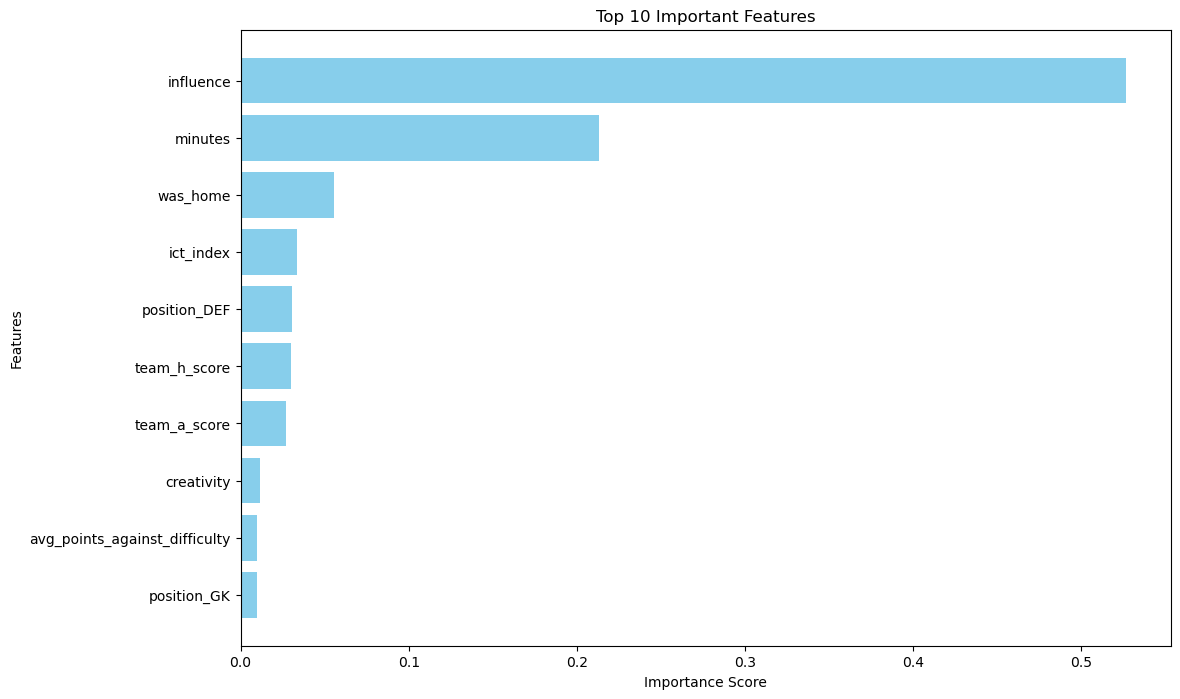

In [18]:
feature_importances = rf_regressor.feature_importances_
features = list(X_train.drop(columns=['name', 'season', 'team', 'opponent_team_name']).columns)
feature_importance_map = dict(zip(features, feature_importances))
sorted_feature_importances = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

#top features
top_features = sorted_feature_importances[:10]
feature_names = [feature[0] for feature in top_features]
importance_scores = [feature[1] for feature in top_features]


plt.figure(figsize=(12, 8))
plt.barh(feature_names, importance_scores, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()
plt.show()


In [19]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Feature Selection: Drop features with very low importance
threshold = 0.001  # Arbitrary threshold for feature importance
important_features = [feature for feature, importance in feature_importance_map.items() if importance > threshold]
unimportant_features = [feature for feature, importance in feature_importance_map.items() if importance < threshold]

X_train_refined = X_train[important_features]
X_val_refined = X_val[important_features]

# Retrain the model
rf_regressor_refined = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_regressor_refined.fit(X_train_refined, y_train)
y_val_pred_rf_refined = rf_regressor_refined.predict(X_val_refined)
rmse_val_rf_refined = mean_squared_error(y_val, y_val_pred_rf_refined, squared=False)

rmse_val_rf_refined

0.7381143274033239

In [25]:
# Hyper parameter tuning on info
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the random forest regressor
rf = RandomForestRegressor(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search model (this will take some time due to the numerous combinations)
grid_search.fit(X_train.drop(columns=['name', 'season', 'team', 'opponent_team_name']), y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_feat

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 5.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 5.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 8.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 8.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 8.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 8.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 8.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 8.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 5.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 5.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  57.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 3.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 3.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 7.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 3.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 7.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 7.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  56.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  57.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 5.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 3.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 5.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 5.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  53.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  57.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  54.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 5.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  54.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  53.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 5.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  55.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  56.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  54.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 4.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 3.0min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 4.6min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 4.9min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  45.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.7min
[CV] END max_depth=None

/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  45.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.6min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.8min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 4.6min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 4.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.5s
[CV] END max_depth=Non

/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 1.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  42.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  41.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.2min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  45.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  39.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  40.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  39.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  41.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  41.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  40.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  40.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  39.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  38.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 1.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  39.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  40.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  38.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 3.3min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  39.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  37.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  44.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  39.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  40.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  39.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 3.2min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 3.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  41.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  41.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  39.0s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  44.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  40.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  43.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 3.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 3.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  41.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  39.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  43.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 3.5min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.2min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 3.6min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  33.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  32.8s
[CV] END max_depth=10, max_features=sqrt

/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  38.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  57.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  33.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  54.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  32.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  33.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  55.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  52.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  56.0s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  55.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  56.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  59.0s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  56.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  59.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  57.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 5.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  58.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  54.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 5.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  54.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  58.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 5.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  55.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  59.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  55.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  54.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  56.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  54.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  57.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 5.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  56.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  55.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 3.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 3.1min
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 5.1min
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 5.0min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  19.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.0min
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 3.1min
[CV] END max_depth=20, max_features=sqr

/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  39.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  41.0s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  41.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 3.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 3.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 3.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 5.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 6.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 6.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 5.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 5.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 5.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 3.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  53.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  55.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  56.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 5.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 5.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 5.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  52.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  55.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  53.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 5.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 5.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 5.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 5.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 3.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 5.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 3.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 5.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 5.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  52.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  57.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  53.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 5.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 4.9min
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 3.2min
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 5.2min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  51.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  53.2s
[CV] END max_depth=30, max_features=auto

/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Hyperparameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [26]:
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [40]:
# Train the model using the best hyperparameters
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train.drop(columns=['name', 'season', 'team', 'opponent_team_name']), y_train)

# Predict on the test set
y_val_pred_rf = rf_regressor.predict(X_val.drop(columns=['name', 'season', 'team', 'opponent_team_name']))
rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))

y_test_pred = best_rf.predict(X_test.drop(columns=['name', 'season', 'team', 'opponent_team_name']))
print(y_test_pred)
# Calculate the RMSE on the test set
#rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
#print("Test RMSE:", rmse_test)

/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[ 2.91206082  4.11399524  0.94023108  1.933612    2.67214885  1.05964436
  7.59977561  2.98223117  1.89901752  1.78626477  2.74281963  2.27494524
  2.6725041   6.16274191  2.29030111  3.76127945  2.78761625  3.36284473
  3.96588968  2.66213554  5.42206277  2.79194921  2.71336291  2.49122199
  2.12770555  0.83544524  3.1256274   0.93752484  2.26426508  7.81708571
  2.81085118  2.27845972  2.00340278  2.85414545  1.85194     0.82468343
  2.97487511  1.73331144  7.16758716  5.16866603  1.83922373  2.5901673
  1.88733492  4.0953619   3.2244868   9.87455     1.89044987  2.65324156
  2.0134525   2.14899269 -0.52449881  1.87418121  2.55842791  2.66063743
  2.30457187  8.02121678  1.5493846   1.13048519  1.67551356  2.94621834
  2.15937937  2.27301805  3.09742641  1.71653216  1.5269239   3.77257123
  1.69387127  1.47426565  4.08832857  0.9082951   2.59749263  2.71297293
  1.40451565  3.9761428   3.35558593  1.99828221  0.26906508  1.55957005
  2.91445088  3.77257123  2.33038862  0.42944762  1.

In [55]:
X_test['xP'] = y_test_pred
X_test['actual_points'] = y_test

print(X_test[['name', 'element', 'team', 'season', 'xP']].where((X_test['team'] == 'Man Utd') & (X_test['xP'] < 3)).dropna())


                                      name  element     team   season  \
781                      Aaron Wan-Bissaka    401.0  Man Utd  2023-24   
2713                    Alejandro Garnacho    382.0  Man Utd  2023-24   
3515                           Alex Telles    370.0  Man Utd  2023-24   
4782                           Amad Diallo    371.0  Man Utd  2023-24   
5960                          AndrÃ© Onana    597.0  Man Utd  2023-24   
7103                       Anthony Martial    390.0  Man Utd  2023-24   
7359             Antony Matheus dos Santos    372.0  Man Utd  2023-24   
12711                     Brandon Williams    374.0  Man Utd  2023-24   
14447             Carlos Henrique Casimiro    376.0  Man Utd  2023-24   
23608                 Diogo Dalot Teixeira    377.0  Man Utd  2023-24   
24492                    Donny van de Beek    400.0  Man Utd  2023-24   
27334                          Eric Bailly    375.0  Man Utd  2023-24   
29158            Facundo Pellistri Rebollo    394.0

In [61]:
samp = X_train[['name', 'element', 'team', 'season']].where((X_train['team'] == 'Man Utd')).dropna()